C:\Users\Leonor Moura\AppData\Local\Temp\ipykernel_18244\956194078.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hog_df_selected['Pawpularity'] = train_df['Pawpularity']


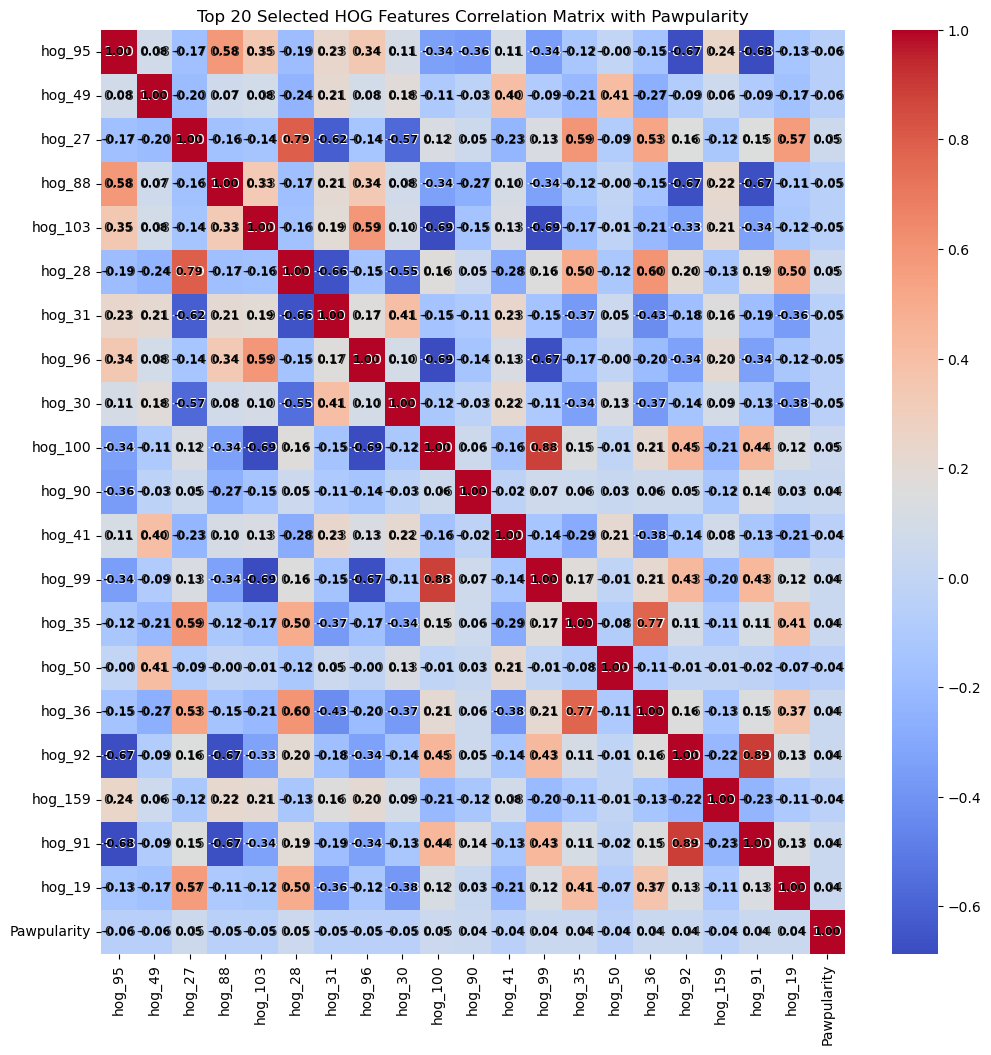

In [7]:
# Load in packages
import os
import seaborn as sns
import pandas as pd
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
from skimage.filters import gabor
from skimage import img_as_ubyte
from skimage.feature import local_binary_pattern
import mahotas
from skimage.feature import hog
from sklearn.decomposition import PCA

# Source path (where the Pawpularity contest data resides)
path = "C:/Users/Leonor Moura/Documents/faculdade/bioengenharia/BIOMEDICA 3/Mestrado/daco/projeto/"

# Get the metadata (the .csv data) and put it into DataFrames
train_df = pd.read_csv(path + 'train.csv')

# Get the image data (the .jpg data) and put it into lists of filenames
train_jpg = glob(path + "train/*.jpg")
# List to store HOG features
hog_feature_list = []

for image_path in train_jpg:
    # Load image
    image = cv.imread(image_path)
    # Convert to grayscale
    gray_image = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    # Resize image
    gray_image = cv.resize(gray_image, (128, 64))

    # Convert image to unsigned byte (required for Gabor filter)
    image_ubyte = img_as_ubyte(gray_image)

    # Extract HOG features
    fd, _ = hog(gray_image, orientations=8, pixels_per_cell=(16, 16), cells_per_block=(1, 1), visualize=True)

    # Add HOG features to the list
    hog_feature_list.append(fd.flatten())

    # Calculate other features (Gabor, Haralick, Luminance, Saturation, LBP) as in your existing code

# Create DataFrame with HOG features
hog_columns = ['hog_' + str(i) for i in range(len(hog_feature_list[0]))]
hog_df = pd.DataFrame(hog_feature_list, columns=hog_columns)

# Aplicar PCA às características HOG
n_components = 21  # Escolha um número maior ou igual a 21
pca = PCA(n_components=n_components)
hog_pca = pca.fit_transform(hog_df)


# Selecionar as 20 melhores características HOG
top_hog_features = hog_df.corrwith(train_df['Pawpularity']).abs().nlargest(20).index
hog_df_selected = hog_df[top_hog_features]

# Adicionar 'Pawpularity' ao DataFrame HOG selecionado
hog_df_selected['Pawpularity'] = train_df['Pawpularity']

# Criar a matriz de correlação entre as características HOG selecionadas e 'Pawpularity'
hog_selected_correlation_matrix = hog_df_selected.corr()

# Display the correlation matrix with numerical values
plt.figure(figsize=(12, 12))
sns.heatmap(hog_selected_correlation_matrix, cmap='coolwarm', annot=True, fmt='.2f')

# Print numerical values in the correlation matrix
for i in range(hog_selected_correlation_matrix.shape[0]):
    for j in range(hog_selected_correlation_matrix.shape[1]):
        plt.text(j + 0.5, i + 0.5, f"{hog_selected_correlation_matrix.iloc[i, j]:.2f}",
                 ha='center', va='center', fontsize=4, color='black)

plt.title('Top 20 Selected HOG Features Correlation Matrix with Pawpularity')
plt.show()

In [8]:
import pandas as pd
# Ler o CSV existente
existing_data = pd.read_csv('../features.csv')

# Remover as duas últimas colunas
existing_data = existing_data.iloc[:, :-2]

# Adicionar as características HOG ao DataFrame existente
existing_data = pd.concat([existing_data, hog_df_selected], axis=1)

#adicionar a coluna de pawpularity normalizada
existing_data['Pawpularity'] = train_df['Pawpularity']/100



# Salvar o DataFrame atualizado de volta ao mesmo arquivo CSV
existing_data.to_csv('../features.csv', index=False)